# Data Science Interview

This interview will have a series of questions and in the end there's a simple dataset for us to understand your abilities in general.

* There's some general questions for us to understand you better as a person
* There's some more specific questions in Data Science Theory

## 1. Can you tell me the difference between Time Series Forecasting and Regression 

Regression refers to determining how an independant variable is related to a set of dependant variables.

Time series forecasting refers to predicting a future value given a time series of data, and multiple methods of performing time series forecasting are available, one of which is regression. 

## 2. Can you tell me the pipeline from the start to the end to create a Model

The pipeline to create a model can be broken down into 8 steps:

1. Problem formulation
2. Data preparation
    1. Ingestion
    2. Cleaning
    3. Feature engineering
    4. Segregation
3. Choose and train model
4. Evaluate model
5. Tune model

## 3. How to prevent overfitting of data?

Methods to prevent overfitting of data include:

* Cross-validation
* Train with more data
* Remove features
* Early stopping
* Regularisation
* Ensembling

## 4. What are recommender systems?

Recommender systems recommended content to a user, and are frequently used by content-based companies. There are three types of recommended systems:

* Content-based
* Collaborative-based
* Hybrid

Content-based recommended systems use the properties of the content, and optionally properties of the user, to recommended content to the user. An example would be recommending restaurants to a user based his cuisine and dietary preferences.

Collaborative filtering systems make recommendations based on the user's ongoing preferences in the content database. An example would be recommending restaurants to a user based on his restaurant visit history.

Combining both models (collaborative filtering and content-based) is a hybrid system, and is typically more accurate than each type individually.

## Using the Dataset

In this dataset, there's only 1 column which is Irradiance. Irradiance is a feature that heavily impacts the accuracy of the forecast against solar energy. The more accurate your irradiance, the more accurate your forecast will be. Think of irradiance as pretty much having a 1 to 1 correlation with solar power however depending on the capacity of the site. 

The dataset consist of:

- Start_Period: Start period of Irradiance being measured
- End_Period: End Period of Irradiance being measured
- Period: Basically, 15 Minute Interval
- Ghi: Irradiance (Global Horizontal Irradiance)

The data gathered is in Singapore, Latitude: 1.36442, Longitude: 103.991531

Some research papers:
- https://www.sciencedirect.com/science/article/pii/S1877050917318392
- https://www.researchgate.net/publication/272647724_Short-Term_Solar_Irradiance_Forecasting_Model_Based_on_Artificial_Neural_Network_Using_Statistical_Feature_Parameters
- https://www.sciencedirect.com/science/article/abs/pii/S0038092X12003039

One of the more powerful solar library that you can use is:
https://pysolar.readthedocs.io/en/latest/

Do some further reading, and using the knowledge you gathered, figure out a way to do the following:

- Feature Engineering
- Time Series Forecasting Vs Regression? (Which methodology to do and which is more accurate)

Forecasting Horizon that we are looking at:

- 1 Hour Ahead (in 15 minutes resolution)
- 1 Day (in 1 hour resolution)

Share with us the performance of your model! :) 

You can use whichever library you are proficient in :) [Tensorflow, PyTorch and Keras is fine]

# Prediction of GHI

## Purpose

Irradiance correlates well to solar power (assumption of 1 to 1 relation), and thus is a variable of interest when trying to predict solar power. The specific irradiance indicator of interest here is Global Horizontal Irradiance (GHI).

## Methodology

1. Obtaining data
    1. Get additional data, relevant indices
    2. Ingest files
2. Cleaning data
    1. Examine data – identify errors, missing values, corrupted records etc
    2. Clean data – Remove, replace, fill missing values/errors
3. Exploring/visualising data
    1. Find patterns in data
    2. Feature engineering
4. Modelling data
    1. Create predictive models
        1. Time series forecasting – LSTM
        2. Regression
    2. Evaluate and refine model
5. Intepreting data

## WIP - improvements

TODOs:

* Establish baseline (e.g. persistence)
* Add other factors (cloud cover index etc)
* check overffitting and bias
* check if answers make sense (negative values)

# Results

LSTM RMSE (2000 epochs): 20.593
LSTM RMSE (500 epochs): 112.735
Regression RMSE: 353.562

# Setup

## Library import

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

from math import sqrt
from datetime import datetime

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# ML libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Stats libraries
from statsmodels.tsa.stattools import adfuller
import missingno as msno

# Plotting libraries
import matplotlib.pyplot as plt
plt.close("all")
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data import

In [3]:
# !wget https://gitlab.com/melvinkokxw/resync-data-science-test/-/raw/master/singapore_irradiation.csv
df = pd.read_csv(
    filepath_or_buffer="singapore_irradiation.csv",
    parse_dates=["PeriodStart", "PeriodEnd"],
    )
df.head()

PeriodEnd               PeriodStart Period  Ghi
0 2007-01-01 01:00:00+00:00 2007-01-01 00:45:00+00:00  PT15M  174
1 2007-01-01 01:15:00+00:00 2007-01-01 01:00:00+00:00  PT15M  214
2 2007-01-01 01:30:00+00:00 2007-01-01 01:15:00+00:00  PT15M  254
3 2007-01-01 01:45:00+00:00 2007-01-01 01:30:00+00:00  PT15M  294
4 2007-01-01 02:00:00+00:00 2007-01-01 01:45:00+00:00  PT15M  339

# Data processing

## Data Cleaning

Using missingno library to visualise any missing data

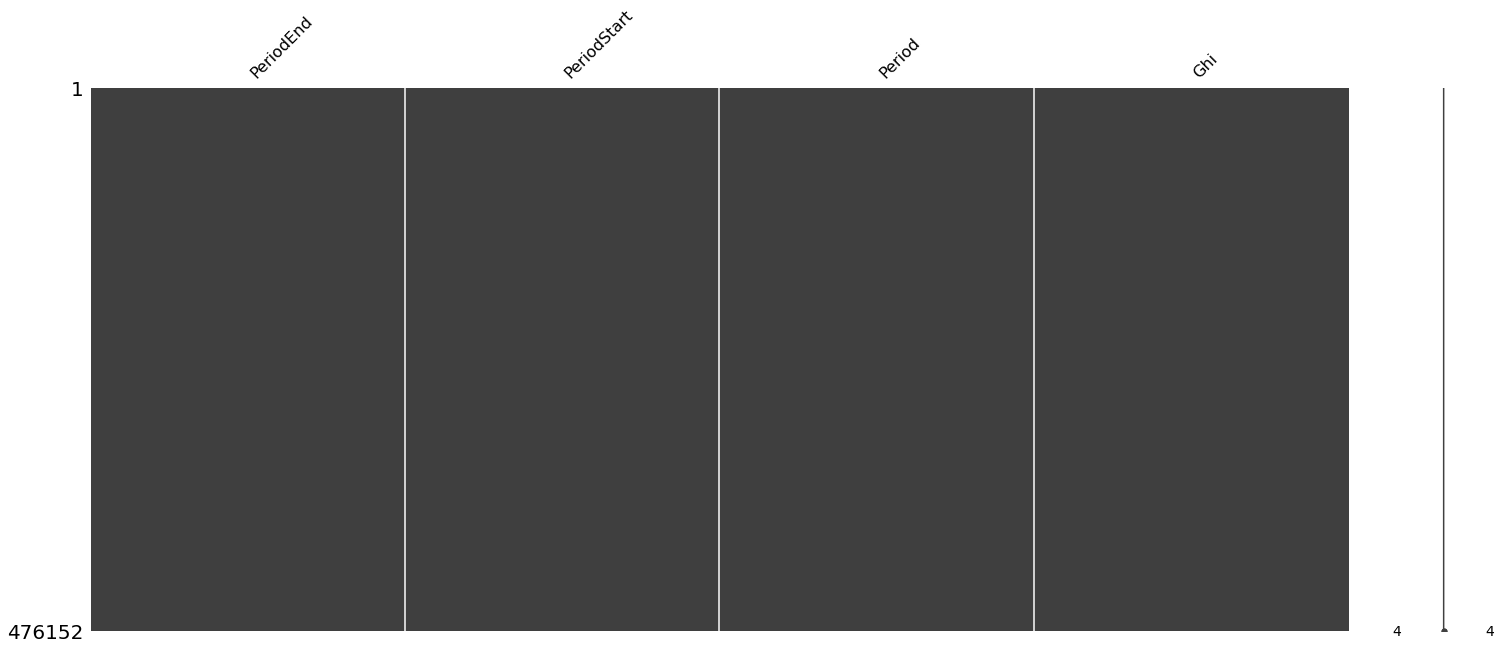

In [4]:
msno.matrix(df)

It appears that there is no missing data – we can confirm that by calculating that using pandas

In [5]:
df.isna().sum()

PeriodEnd      0
PeriodStart    0
Period         0
Ghi            0
dtype: int64

## Exploring Data

Since data is time series, we can use a time series as the dataframe index. A suitable column would be the `PeriodStart` column.

In [6]:
df.set_index("PeriodStart", inplace=True)

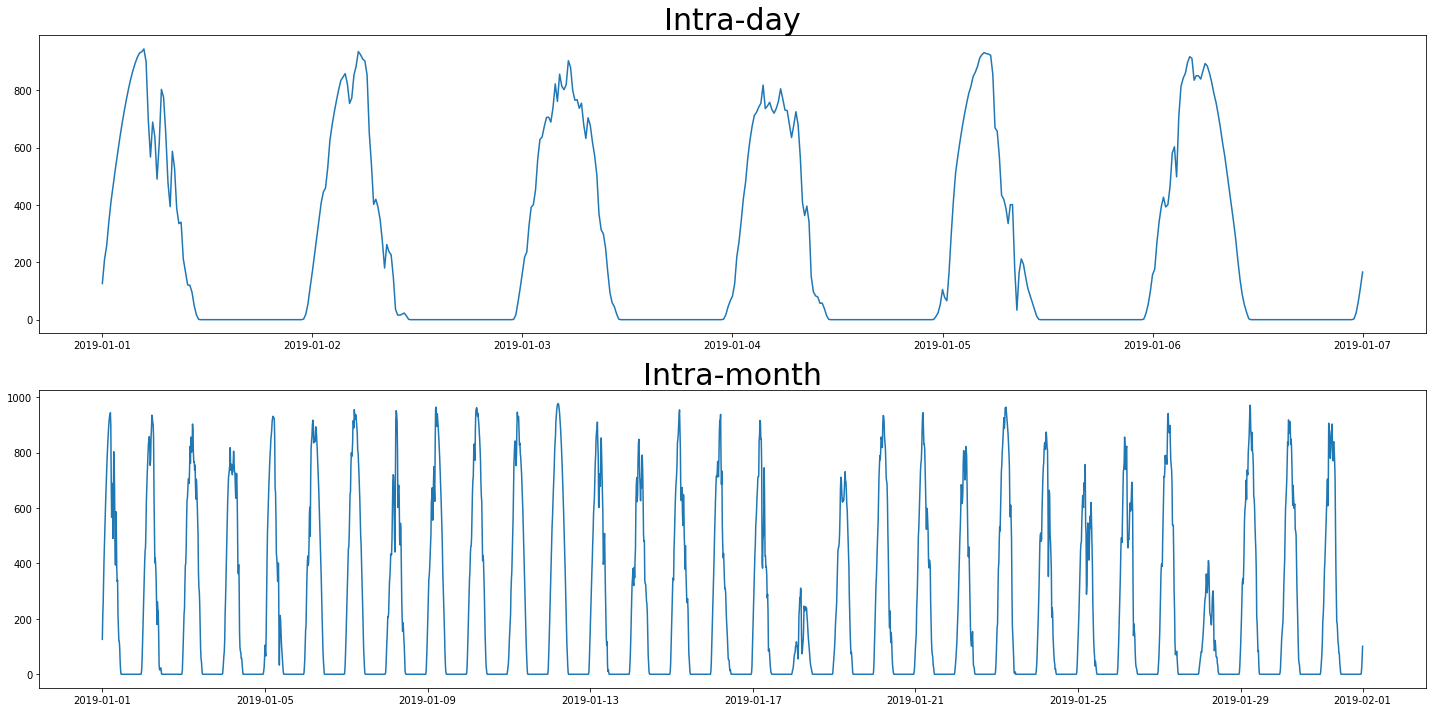

In [7]:
df_week = df[datetime(2019,1,1):datetime(2019,1,7)]
df_month = df[datetime(2019,1,1):datetime(2019,2,1)]

fig, axs = plt.subplots(2, 1, figsize=[20,10])
axs[0].plot(df_week.index, df_week["Ghi"])
axs[0].set_title("Intra-day", fontdict={"fontsize": 30})
axs[1].plot(df_month.index, df_month["Ghi"])
axs[1].set_title("Intra-month", fontdict={"fontsize": 30})
fig.tight_layout()

We can observe that GHI follows a seasonality on a daily scale, increasing in the first half of the day and peaking near noon, then falling to 0 at nighttime, following the diurnal cycle

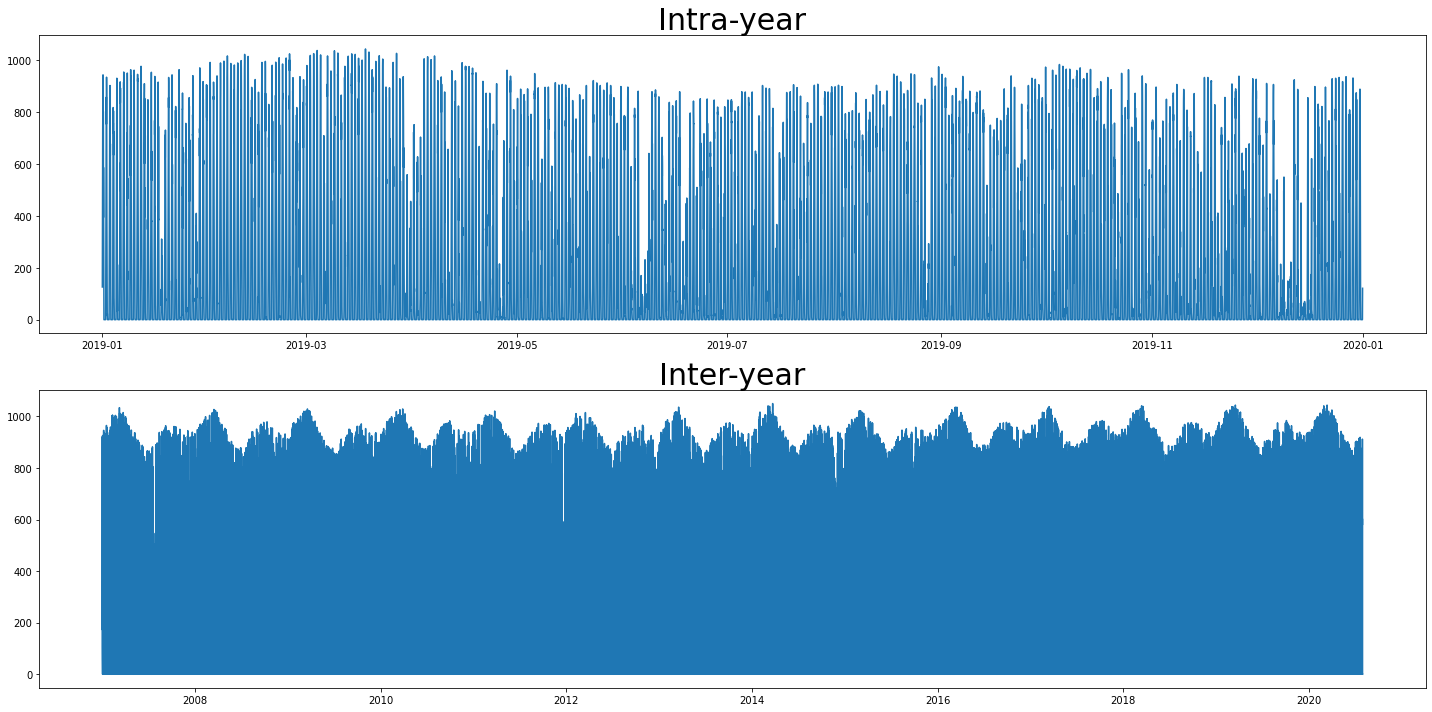

In [8]:
df_year = df[datetime(2019,1,1):datetime(2020,1,1)]

fig, axs = plt.subplots(2, 1, figsize=[20,10])
axs[0].plot(df_year.index, df_year["Ghi"])
axs[0].set_title("Intra-year", fontdict={"fontsize": 30})
axs[1].plot(df.index, df["Ghi"])
axs[1].set_title("Inter-year", fontdict={"fontsize": 30})
fig.tight_layout()

We can observe seasonality in GHI, increasing between January and March, and falling between April and June. It increases again between July and September, and falls again between October and December.

To determine if the series is stationary, we examine the data statistically. Statistical testing is done using the Augmented Dickey-Fuller test.

In [9]:
result = adfuller(df["Ghi"])
print("ADF Statistic: {}".format(result[0]))
print("p-value: {}".format(result[1]))
print("Critical Values:")
for key, value in result[4].items():
    print("\t{}: {}".format(key, value))

Since the p-value is small (0) and below the threshold (0.05), we can conclude that the data is stationary and does not need adjusting for trends.

Note: Output for this cell was not generated on this run due to RAM limitations.

In [10]:
dataset = df[["Ghi"]].values

sc = MinMaxScaler()
dataset = sc.fit_transform(dataset)

def sliding_windows(data, seq_length, time_ahead):
    x = []
    y = []

    for i in range(len(data)-seq_length-time_ahead-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length+time_ahead]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

seq_length = 4 # use past 1 hour of data
time_ahead = 4 # predict 1 hour ahead
# time_ahead = 96 # predict 1 day ahead
x, y = sliding_windows(dataset, seq_length, time_ahead)

In [11]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

X = Variable(torch.Tensor(np.array(x)))
Y = Variable(torch.Tensor(np.array(y)))

X_train = Variable(torch.Tensor(np.array(x[0:train_size])))
X_train_regression = X_train.reshape(X_train.shape[0], X_train.shape[1])
Y_train = Variable(torch.Tensor(np.array(y[0:train_size])))

X_test = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
Y_test = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Modelling data

In [12]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

class Regression(nn.Module):

    def __init__(self):
        super(Regression, self).__init__()
        self.fc = nn.Sequential(
                      nn.Flatten(1),
                      nn.Linear(4, 200),
                      nn.LeakyReLU(),
                      nn.Linear(200, 100),
                      nn.LeakyReLU(),
                      nn.Linear(100, 1),
                  )

    def forward(self, x):
        output = self.fc(x)
        return output

In [13]:
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

regression = Regression()

models = [
          {
              "name": "regression",
              "model": regression,
              "epochs": 100
          },
          {
              "name": "lstm",
              "model": lstm,
              "epochs": 500
          }
]

criterion = nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the models
for model in models:
  print("Training {} model".format(model["name"]))
  for epoch in range(model["epochs"]):
      outputs = model["model"](X_train)
      optimizer.zero_grad()

      # obtain the loss function
      loss = criterion(outputs, Y_train)

      loss.backward()

      optimizer.step()
      if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
  torch.save(model["model"].state_dict(), "{}.pth".format(model["name"]))

Training regression model
Epoch: 0, loss: 0.11076
Training lstm model
Epoch: 0, loss: 0.09047
Epoch: 100, loss: 0.02124
Epoch: 200, loss: 0.01668
Epoch: 300, loss: 0.01389
Epoch: 400, loss: 0.00935


In [14]:
lstm.load_state_dict(torch.load("LSTM.pth"))
regression.load_state_dict(torch.load("regression.pth"))
lstm.eval()
regression.eval()

lstm_predictions = sc.inverse_transform(lstm(X).data.numpy())
regression_predictions = sc.inverse_transform(regression(X).data.numpy())
Y_base = sc.inverse_transform(Y.data.numpy())

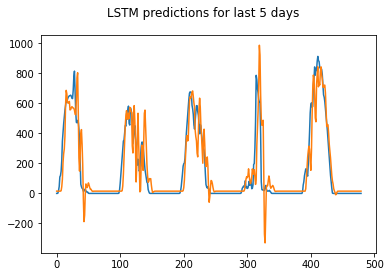

In [15]:
# plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(Y_base[-480:])
plt.plot(lstm_predictions[-480:])
plt.suptitle("LSTM predictions for last 5 days")
plt.show()

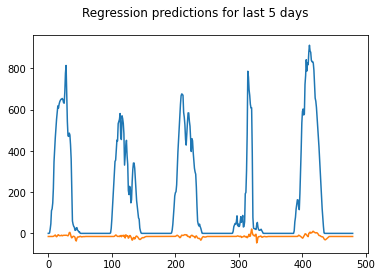

In [16]:
# plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(Y_base[-480:])
plt.plot(regression_predictions[-480:])
plt.suptitle("Regression predictions for last 5 days")
plt.show()

In [17]:
lstm_rmse = sqrt(mean_squared_error(Y_base, lstm_predictions))
regression_rmse = sqrt(mean_squared_error(Y_base, regression_predictions))
print("LSTM RMSE: %.3f" % (lstm_rmse))
print("Regression RMSE: %.3f" % (regression_rmse))

LSTM RMSE: 112.735
Regression RMSE: 353.562


## General Question: Why do you want to join RESYNC? 

I am applying for this position as I am very interested in building a career in the engineering industry. I want to apply my skills to solve real world problems, such that I can see a direct benefit to the lives of those around me. 

Specifically, I want to work in a data science position, where I can design and execute systems to solve problems. This is something appealing to me because I enjoy coming up with ways to efficiently overcome challenges posed to me, which is an important part of a data scientist’s job scope. 

From my understanding, this position of Data Scientist Intern requires me to work on Resync's forecasting models, specifically to develop and improve the models for predicting solar power generation. This is very appealing to me and I believe I would greatly enjoy my work here, hence I applied for this position.


## General Question: What's your goal in life and what you hope to achieve by joining RESYNC?

My goal in life is to become a professional computer engineer specialising in data science, but with competencies across various aspects, which include general engineering knowledge and applications of machine learning. 

I have two objectives for this internship – the first is to increase my experience with data science and the second is to gain exposure to the workings in a successful start-up. 

I have always been interested in data science, as it is a useful application of machine learning to real world problems. I want to build upon my knowledge from my studies and apply them to be proficient in solving engineering problems using data science.

Secondly, I have always been interested in the workings of a successful start-up. Resync is a fairly new company, being less than 5 years old, and yet it has strong clients and projects. I wish to learn how the team and company is run to bring it to this level.
